<img src="https://drive.google.com/uc?id=1zDNI5DqbrfvgrgEraXgvIv0A8WZxT-g1"/>


# Computer vision assigment

Hi,

This is an off-site asynchronous computer vision test to join the PhotoRoom team.

## Context
You're in the process of joining the PhotoRoom team, this test will help us to know more about the way you work and you communicate. Machine learning powers the core of our product and we are always working to improve it.

There's no trap: the goal is for us to know better your work habits, the way you arbitrage, communicate and code. We'd like to avoid taking too much of your time, **please don't spend more than 3 hours** on the test. We can accept an unfinished project, as long as it displays quality and it's well explained. This is an open ended exercise allowing you to showcase areas of machine learning where you excel.

## Exercise
You will train a model for facial keypoint detection. For the purpose of this exercise, we'd like you to train a convolutional network on this dataset. While you are free to take the object detection route, we recommend to treat this as an image to image translation problem, where you predict heatmaps of the keypoints.

<img src="https://drive.google.com/uc?id=1u6wC_x3hOwG6rlcpFOJqjcIYzzNtmFDV"/>


We provide a small dataset of images and labels. We detail below the outline of the viable training code we'd like you to achieve. If time allows we encourage you to work further on one of the areas. Choose one which you feel can showcase your ML talent best. Afterwards we will discuss with you which choices you made and encourage you to explain why.

## Required Features

1. Dataloader for images and labels
2. Convolutional neural network to predict label from image
3. Loss function to compute prediction error
4. Training loop to train model
5. Validation loop to evaluate model
6. Visualisation of results and brief commentary on model accuracy.

All choices within those are down to you. We **don't expect incredible model performance**, but we do want a running model. We are fully aware of the time, hardware and dataset constraints. We are not evaluating raw accuracy.


## Suggestions for optional improvements

Network accuracy, speed, memory or the training code. E.g: extra data augmentation, hyperparameter search, network architecture, losses, logging.


## Rules

- For the purposes of this test, we'll only communicate in English and over emails
- You can use any library, framework or model
- You can check for help on the internet (like StackOverflow), no shame here
    - **You must give references to the source code.**
- You must ask us if you encounter any blocker, or if you're not sure to understand perfectly what we're expecting from you
- At the end of the exercise, send a link to a public Github repository (or private if you prefer, in which case invite Eliot [[EliotAndres](github.com/eliotandres/)])
- **All of the code** necessary to complete the assignment **must be included in this colab notebook.** While we understand that having separate python files may sometimes be cleaner than a notebook, this is to ensure that all candidates have access to at least one GPU.
- After receiving the code and reviewing it, we'll schedule a 30 minutes call to discuss your work. Please be prepared to share your screen.

# What's evaluated

- Understanding of what we're expecting
- Proficiency with machine learning techniques
- Technical choices and their underlying explanations
- Code readability/simplicity over performance


We will provide a sample code to load the dataset and extract both the images and the facial landmarks from the csv file.



# Using The GPU
In order to use the GPU inside Colab, go to the Runtime tab and click on Change Runtime Type. Then select GPU from the dropdown menu.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install -U --no-cache-dir gdown --pre
!gdown https://drive.google.com/uc?id=162YTEfBHItdy5UwqwqeXf5whXRQDcb1Q

You should consider upgrading via the '/users/r/ramzie/dev/generalization/.venv/bin/python3 -m pip install --upgrade pip' command.
Downloading...
From (original): https://drive.google.com/uc?id=162YTEfBHItdy5UwqwqeXf5whXRQDcb1Q
From (redirected): https://drive.google.com/uc?id=162YTEfBHItdy5UwqwqeXf5whXRQDcb1Q&confirm=t&uuid=6814e0ba-197b-4484-ad3d-848ab6b0b68e
To: /users/r/ramzie/dev/photoroom/notebooks/training.csv
100%|████████████████████████████████████████| 238M/238M [00:03<00:00, 61.6MB/s]


In [3]:
df_train = pd.read_csv('training.csv')
print(f"DataFrame Shape {df_train.shape}")
df_train.head(2)

DataFrame Shape (7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


### How to retrieve the data from the csv :

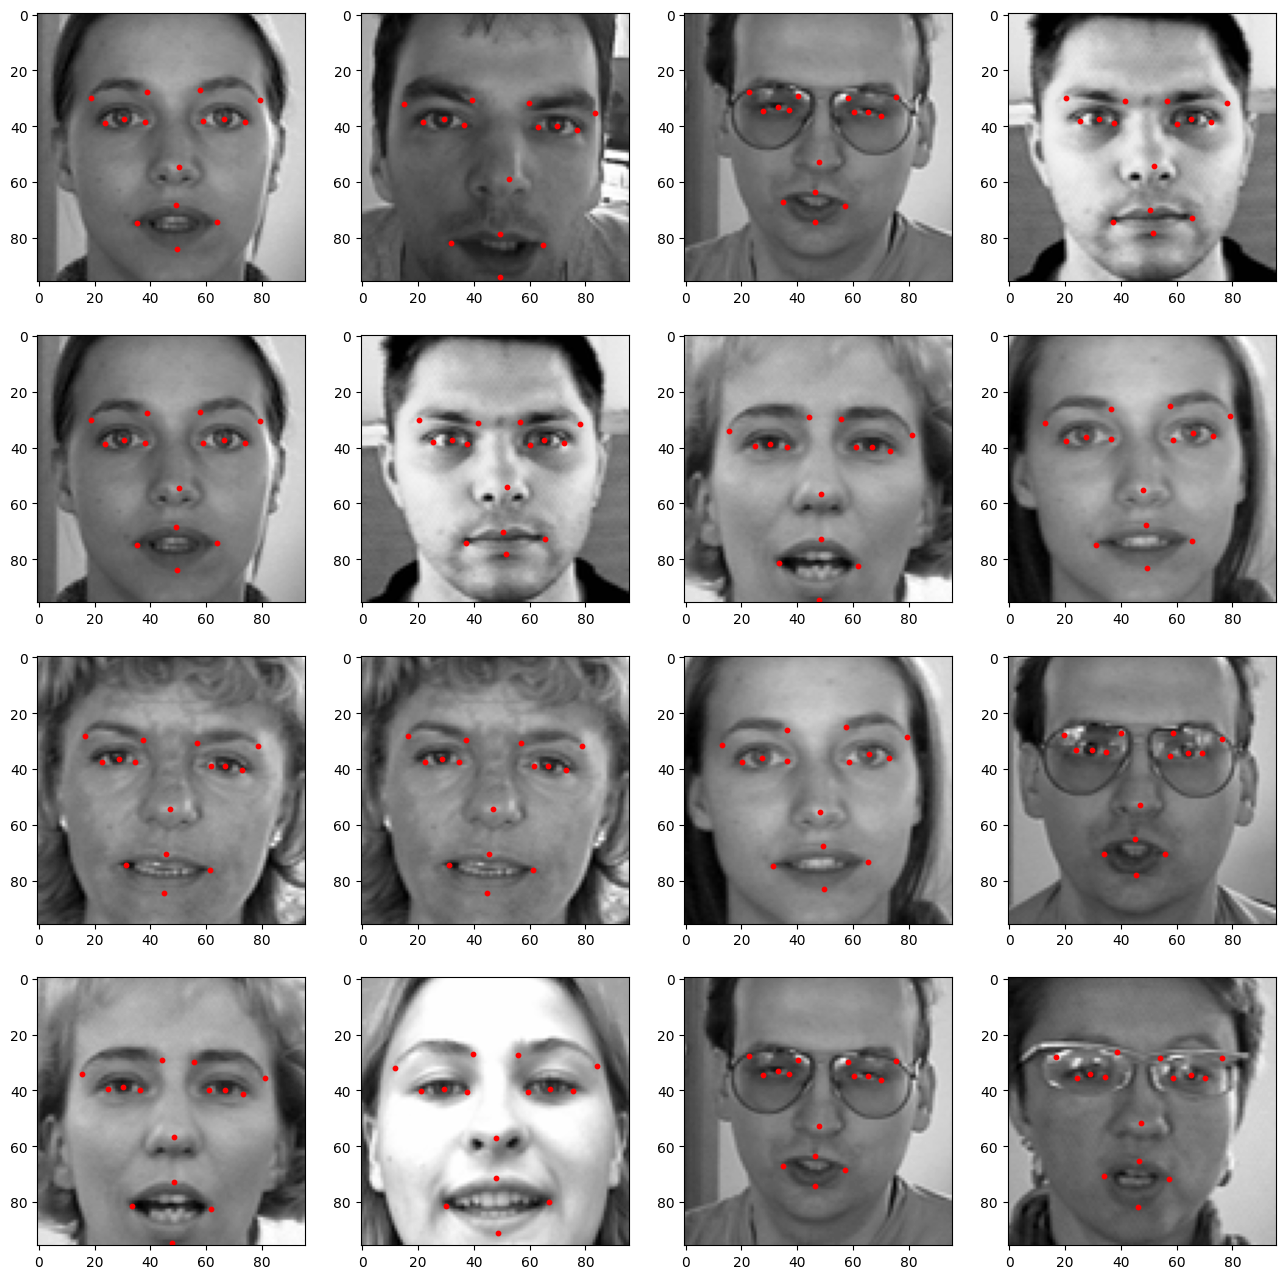

In [4]:
feature_col = 'Image'
target_cols = list(df_train.drop('Image', axis=1).columns)

# Fill missing values
df_train[target_cols] = df_train[target_cols].fillna(df_train[target_cols].mean())

# Image characteristics
IMG_WIDTH  = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 1

raw_images = np.array(df_train[feature_col].str.split().tolist(), dtype='float')
images = raw_images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

labels = df_train[target_cols].values

def show_examples(images, landmarks):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

    for img, marks, ax in zip(images, landmarks, axes.ravel()):
        # Keypoints
        x_points = marks[:: 2]
        y_points = marks[1::2]

        ax.imshow(img.squeeze(), cmap='gray')
        ax.scatter(x_points, y_points, s=10, color='red')

    plt.show()


idx = np.random.choice(16, 16)
show_examples(images[idx], labels[idx])

In [5]:
from typing import Tuple, Callable
import copy
import random
from itertools import product

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.optim import Optimizer, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.models import resnet18, resnet50
from torchvision.models import ResNet18_Weights, ResNet50_Weights

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [6]:
def expand_gray_scale(gray_scale_image: np.ndarray) -> np.ndarray:
    """
    This function turns a grayscale image into a RGB format image, which is needed to use
    pretrained networks
    """
    return np.concatenate((gray_scale_image, gray_scale_image, gray_scale_image), axis=2).astype(np.uint8)

# This is a simple transform, with no data augmentation --> leads to ~3.1 MSE on the test set
basic_transform = T.Compose([
    expand_gray_scale,
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


# Possible amelioration on the data side
# - Data augmentation, it requires using augmentation on both image and target
# - Normalize the keypoints

def horizontal_flip(image: Tensor, points: Tensor, p: float) -> Tuple[Tensor, Tensor]:
    """
    adapted data augmentation from here:
    https://medium.com/@maverick_nerd/facial-keypoints-detection-using-pytorch-d34393b39958
    however training does not converge with it.
    """
    flip_indices = [(0, 4), (1, 5), (2, 6), (3, 7),
                    (8, 12), (9, 13), (10, 14), (11, 15),
                    (16, 18), (17, 19)]

    if np.random.random() < p:
        image = TF.hflip(image)
        for a, b in flip_indices:
            points[a], points[b]= points[b], points[a]
        points[::2] = 96. - points[::2]

    return image, points


class CustomDataset(Dataset):
    
    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        transform: Callable = None,
        horizontal_flip_p: float = 0.,
) -> None:
        self.images = images.copy()
        self.labels = labels.copy()
        self.transform = transform
        self.horizontal_flip_p = horizontal_flip_p
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, idx: int) -> Tuple[Tensor]:
        img = self.images[idx].astype(np.float32)
        lb = torch.from_numpy(self.labels[idx])
        
        if self.transform:
            img = self.transform(img)
        
        if self.horizontal_flip_p > 0:
            img, lb = horizontal_flip(img, lb, self.horizontal_flip_p)
        return img, lb


def split(
    full_dataset: Dataset,
    val_percent: float,
    test_percent: float,
    random_seed: int = 42,
) -> Tuple[Dataset, ...]:
    """
    from:
    https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/19?page=2
    
    Splits dataset into train, val and test.
    """
    amount = len(full_dataset)

    test_amount = (
        int(amount * test_percent)
        if test_percent is not None else 0)
    val_amount = (
        int(amount * val_percent)
        if val_percent is not None else 0)
    train_amount = amount - test_amount - val_amount

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        (train_amount, val_amount, test_amount),
        generator=(
            torch.Generator().manual_seed(random_seed)
            if random_seed
            else None))
    
    return train_dataset, val_dataset, test_dataset

In [7]:
full_dataset = CustomDataset(images, labels, basic_transform)
print('Full', len(full_dataset))

train_dts, val_dts, test_dts = split(full_dataset, 0.1, 0.2) # split the data 70%, 10%, 20%
train_dts.dataset = copy.deepcopy(train_dts.dataset)  # this allow using different values for data augmentation
train_dts.dataset.horizontal_flip_p = 0.  # Does not improve results as is

print('Train', len(train_dts))
print('Val', len(val_dts))
print('Test', len(test_dts))

train_loader = DataLoader(train_dts, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_dts, batch_size=256, shuffle=False, drop_last=False, pin_memory=True)
test_loader = DataLoader(test_dts, batch_size=256, shuffle=False, drop_last=False, pin_memory=True)




Full 7049
Train 4936
Val 704
Test 1409


In [8]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.001
AMP = True
PARALLEL = True

# Using ImageNet pretrained network to speedup training
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 30)

_ = model.to('cuda', non_blocking=True)


optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr=1e-5)  # Reduce learning rate if validation loss does not decrease

scaler = torch.cuda.amp.GradScaler(enabled=AMP)

criterion = nn.MSELoss()

if PARALLEL:
    model = nn.DataParallel(model)


In [9]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    criterion: Callable,
    loader: DataLoader,
    scaler: torch.cuda.amp.GradScaler,
) -> float:
    """
    Basic training loop, with autocast option to speed training
    """
    model.train()
    optimizer.zero_grad()
    history = []
    for (img, lb) in loader:
        img = img.to('cuda', non_blocking=True).float()
        lb = lb.to('cuda', non_blocking=True).float()
        with torch.cuda.amp.autocast(enabled=AMP):
            outputs = model(img)
            loss = criterion(outputs, lb)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        history.append(loss.item())
    
    return np.mean(history)


@torch.no_grad()
def evaluate(
    model: nn.Module,
    criterion: Callable,
    loader: DataLoader,
) -> float:
    """
    Basic eval loop
    """
    model.eval()
    history = []
    for (img, lb) in loader:
        img = img.to('cuda', non_blocking=True).float()
        lb = lb.to('cuda', non_blocking=True).float()
        with torch.cuda.amp.autocast(enabled=AMP):
            outputs = model(img)
            loss = criterion(outputs, lb)
            
        history.append(loss.item())
    return np.mean(history)
        

In [ ]:
lr_history = []
train_history = []
val_history = []

iterator = tqdm(range(EPOCHS), 'Training')
for e in iterator:
    loss = train(model, optimizer, criterion, train_loader, scaler)
    val_loss = evaluate(model, criterion, val_loader)
    train_history.append(loss)
    val_history.append(val_loss)
    
    scheduler.step(val_loss)
    lr = scheduler._last_lr[-1]
    lr_history.append(lr)
    
    iterator.set_postfix({'lr': lr, 'train loss': loss, 'val loss': val_loss})


print('Final training loss', loss.item())
print('Final validation loss', val_loss.item())



Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
_ = plt.figure(figsize=(10, 3))
_ = plt.subplot(1, 3, 1)
_ = plt.plot(lr_history, label='Learning rate')
_ = plt.subplot(1, 3, 2)
_ = plt.plot(train_history, label='Train loss')
_ = plt.subplot(1, 3, 3)
_ = plt.plot(val_history, label='Val loss')


In [ ]:
test_loss = evaluate(model, criterion, test_loader)
print('Test loss', test_loss)


In [ ]:
# Qualitative analysis
model.eval()

selected_ids = random.sample(range(len(test_dts)), 5)

for idx in selected_ids:
    plt.figure(figsize=(16, 16))

    plt.subplot(1, 3, 1)
    plt.imshow(test_dts[idx][0][0], cmap='gray')
    plt.title('Image', fontsize=20)

    plt.subplot(1, 3, 2)
    plt.imshow(test_dts[idx][0][0], cmap='gray')
    x_points = test_dts[idx][1][:: 2]
    y_points = test_dts[idx][1][1::2]
    plt.scatter(x_points, y_points, s=10, color='red')
    plt.title('Ground truth', fontsize=20)

    plt.subplot(1, 3, 3)
    plt.imshow(test_dts[idx][0][0], cmap='gray')

    img = test_dts[idx][0].unsqueeze(0).to('cuda', non_blocking=True).float()
    lb = test_dts[idx][1].unsqueeze(0).to('cuda', non_blocking=True).float()
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=AMP):
        outputs = model(img)
        loss = criterion(outputs, lb)
    outputs = outputs[0].cpu().numpy()
    x_points = outputs[:: 2]
    y_points = outputs[1::2]
    plt.scatter(x_points, y_points, s=10, color='red')
    _ = plt.title(f'Prediction, MSE={loss.item():.2f}', fontsize=20)



We are using a simple ResNet-18 with ImageNet pre-training. Using a ResNet-50 with the same hyperparameters does not improve accuracy (MSE loss).

There is a little bit of overfitting, indeed the training loss is lower than the validation loss.
We use the following to reduce overfitting:
- Weight decay did not improve the results.
- Random horizontal flipping, has a bug for now and does not lead to significant improvement of performances.
- Reducing the learning rate using validation set.

Overfitting is still limited. Qualitatively, it is hard to notice difference between predicted value and the ground truth.

The MSE loss is used during training and evaluation.

Let's try doing a grid search.

In [262]:
def get_problem(
    learning_rate: float,
    weight_decay: float,
) -> Tuple[nn.Module, Optimizer, ReduceLROnPlateau]:
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(512, 30)

    _ = model.to('cuda', non_blocking=True)


    optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr=1e-5)

    scaler = torch.cuda.amp.GradScaler(enabled=AMP)

    criterion = nn.MSELoss()

    if PARALLEL:
        model = nn.DataParallel(model)
        
    return model, optimizer, scheduler


def run_experiment_with_config(
    epochs, 
    learning_rate,
    weight_decay,
) -> float:
    model, optimizer, scheduler = get_problem(learning_rate, weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    criterion = nn.MSELoss()
    
    val_history = []

    for e in tqdm(range(epochs), f"Epoch={epochs}, lr={learning_rate}, wd={weight_decay}", leave=None):
        loss = train(model, optimizer, criterion, train_loader, scaler)
        val_loss = evaluate(model, criterion, val_loader)
        val_history.append(val_loss)

        scheduler.step(val_loss)
        
    return np.max(val_history), model




In [263]:
range_epochs = [20, 50, 100, 200]
range_lr = [0.1, 0.01, 0.001]
range_wd = [0., 0.01, 0.0001]

configs = list(product(range_epochs, range_lr, range_wd))

print(f"Launching {len(configs)} experiments")

min_val = float('inf')
best_config = None
for epochs, lr, wd in tqdm(configs):
    val_loss, _ = run_experiment_with_config(epochs, lr, wd)
    if val_loss < min_val:
        min_val = val_loss
        best_config = (epochs, lr, wd)

_, model = run_experiment_with_config(*best_config)

Launching 36 experiments


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch=20, lr=0.1, wd=0.0:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 